## Brand Value and Customer's Reflection

Goal: By comparing user comments to keywords, we will evaluate the alignment of the brand's mission statements (how they intend to potray themselves) to user's perception of their brands. We aim to quantify how much consumers reflect the brand's values. 

The alignment is calculated using TF-IDF alignment score and cosine similarity



In [77]:
import pandas as pd
import numpy as np
import spacy
from scipy.stats import zscore
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity 
import seaborn as sns
import matplotlib.pyplot as plt

In [137]:
#Loading the data
brand_value = pd.read_csv("Brands  - Sheet1.csv")
user_comment = pd.read_csv("subreddit_comment_data.csv")

brand_value.columns = brand_value.columns.str.strip().str.lower()
user_comment.columns = user_comment.columns.str.strip().str.lower()

user_comment["brand"] = user_comment["brand"].replace(brand_mapping) 

user_comment = user_comment[user_comment["brand"].notna()]

user_comment["brand"].unique()

brand_mapping = {
    'fenty': 'Fenty Beauty',
    'Fenty': 'Fenty Beauty',
    'etude': 'Etude House',
    'e.l.f.': 'e.l.f. Cosmetics',
    'Etude': 'Etude House',
    'elf': 'e.l.f. Cosmetics', 
    'Tarte': 'Tarte Cosmetics'
}
user_comment = user_comment.dropna(subset=["brand"])

def normalize_brand(name):
    return brand_mapping.get(name.lower().strip(), name.strip())

user_comment["normalized_brand"] = user_comment["brand"].apply(normalize_brand)

user_comment["brand"].unique()

array(['Estée Lauder', 'Fenty Beauty', 'e.l.f. Cosmetics',
       'Tarte Cosmetics', 'Glossier', 'Laneige', 'Sulwhasoo',
       'Etude House', 'Innisfree', 'COSRX'], dtype=object)

In [138]:
brand_value = brand_value.rename(columns={"brand": "search_term", "values/ mission": "brand_mission"})

new_df = user_comment.merge(
    brand_value[["search_term", "brand_mission"]],
    left_on="brand",
    right_on="search_term",
    how="inner"
)

new_df["brand"].unique()

array(['Estée Lauder', 'Fenty Beauty', 'e.l.f. Cosmetics',
       'Tarte Cosmetics', 'Glossier', 'Laneige', 'Sulwhasoo',
       'Etude House', 'Innisfree', 'COSRX'], dtype=object)

In [124]:
print(new_df.columns) 

Index(['post_id', 'title', 'brand', 'subreddit_name', 'comment',
       'cleaned_comment', 'normalized_brand', 'search_term', 'brand_mission'],
      dtype='object')


In [139]:
#Using TF-IDF alignment score 
#Term Frequency – Inverse Document Frequency 
# The text is converted into a vector of numbers, representing the importance of the words in the comment column and the brand_mission column 
# relative to each other 
#fit_transform builds a vocabulary from the strings "comment" and "brand_mission", then term frequency is computed for each one 
# Inverse-document frequencies are then computed based on the two texts

def get_alignment_score(row):
    key_columns = [str(row["brand_mission"]), str(row["comment"])]
    vectorizer = TfidfVectorizer(stop_words="english")
    tfidf = vectorizer.fit_transform(key_columns)
    return cosine_similarity(tfidf[0], tfidf[1])[0][0] 
    #1 is perfectly align 
    #0 is no alignment 

new_df["alignment_score"] = new_df.apply(get_alignment_score, axis = 1)

new_df["brand"].unique()


array(['Estée Lauder', 'Fenty Beauty', 'e.l.f. Cosmetics',
       'Tarte Cosmetics', 'Glossier', 'Laneige', 'Sulwhasoo',
       'Etude House', 'Innisfree', 'COSRX'], dtype=object)

In [140]:
#Summary Data 
new_df["z_score"] = new_df.groupby("brand")["alignment_score"].transform(zscore)

insight = new_df.groupby("brand").agg(
    mean_alignment = ("alignment_score", "mean"), 
    mean_z_alignment = ("z_score", "mean")).reset_index()

insight 

,brand,mean_alignment,mean_z_alignment
0,COSRX,0.037223,3.828355e-17
1,Estée Lauder,0.008010,-5.396917e-17
2,Etude House,0.013651,-9.880803e-17
3,Fenty Beauty,0.031863,1.164172e-17
4,Glossier,0.031701,-8.233828e-17
5,Innisfree,0.013517,1.071662e-16
6,Laneige,0.024914,2.831441e-17
7,Sulwhasoo,0.049947,9.589399e-17
8,Tarte Cosmetics,0.020147,9.293722e-17
9,e.l.f. Cosmetics,0.013340,1.081198e-16


In [141]:
#Classify the alignment score into top alignments and create a new dataframe

top_alignment_comment = new_df.sort_values("alignment_score", ascending=False).drop_duplicates("brand")
top_alignment_comment["alignment_type"] = "Top Aligned"

low_alignment_comment = new_df.sort_values("alignment_score", ascending=True).drop_duplicates("brand")
low_alignment_comment["alignment_type"] = "Lowest Aligned"

both_df = pd.concat([top_alignment_comment, low_alignment_comment]).sort_values(["brand", "alignment_type"])

both_df


post_id  \
2077  110wklo   
4508  1928sit   
0     1bv7f30   
1142  15bkq6b   
2961   acmxy1   
3204  1get5qu   
2133   eg61ua   
1268  144ewuz   
2273   e2z9n3   
418    ak63ht   
2071  12qb50k   
3253   3fai0w   
2528  1bjbyj7   
2283   g65r2s   
2569  16xkmki   
2815   yu70y2   
2201   alqq7k   
1523  1fquptv   
2154  15zanjh   
173    5pinr0   

                                                                                                                                                                                                                                                                                                             title  \
2077  hi!! ever since starting differin im really drying out. i use the COSRX all in one snail cream + the vanicream lotion for my main moisturizers but i want to add a hydrating, skin barrier repairing serum OR toner into my routine. any recs? i live in canada so pls stuff that’s available in our sephora   
4508                                                                                                                                                                                                                         COSRX Advance Snail 96 Mucin Power Essence vs COSRX Advance Snail 96 All in one cream   
0                                                                                                                                                                                                                                                                   [Product Question] Estée Lauder ANR - Allergic   
1142                                                                                                                                                                                                                                                    What can I add to Estée Lauder Foundation to make it glow?   
2961                                                                                                                                                                                                                                                         [REVIEW] Etude House - Hot Style Bubble Hair Coloring   
3204                                                                                                                                                                                                                                                                Etude’s Holiday Collections Going Back to 2010   
2133                                                                                                                                                                                                                                  Looking for some AB alternatives to this new Fenty Beauty eyeshadow palette!   
1268                                                                                                                                                                                                                                                    Rare Beauty Tinted Moisturizer or Fenty Beauty Eaze Drops?   
2273                                                                                                                                                                                                                                                 New product from COSRX | AHA BHA Vitamin C Daily Toner 280 ml   
418                                                                                                                                                                                                                  [Review] Glossier Milky Jelly, DR Jarts Cicapair Serum, FAB Ultra Repair Cream and more below   
2071                                                                                                                                                                                                                      Thoughts on Shiseido

In [147]:
pd.set_option("display.max_colwidth", None)
top_alignment_comment[["comment", "brand", "brand_mission", "alignment_score"]]

comment  \
2815                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

## Visualization of Alignment Score
Comparision between Korean and US Brands 

In [143]:
# Categorize the brands base on country

insight["country"] = "US Brand"

korean_brands = ["COSRX", "Etude House", "Innisfree", "Laneige", "Sulwhasoo"]
insight.loc[
    insight["brand"].str.contains("|".join(korean_brands), case=False),
    "country"] = "Korean Brand" 

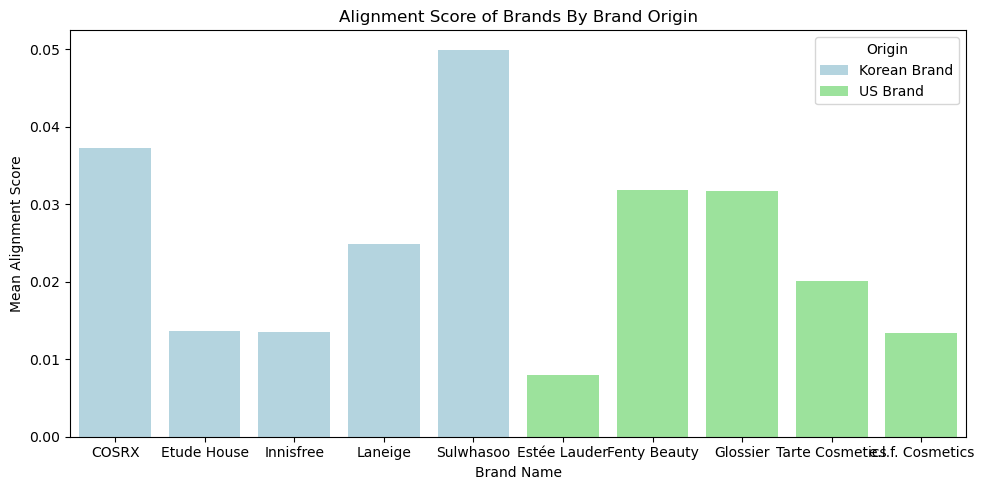

In [144]:
sorted_by_country = insight.sort_values(by=["country", "brand"])

plt.figure(figsize=(10, 5))
sns.barplot(data=sorted_by_country, x="brand", y="mean_alignment", hue="country", palette={"Korean Brand": "lightblue", "US Brand": "lightgreen"})

plt.title("Alignment Score of Brands By Brand Origin")
plt.xlabel("Brand Name")
plt.ylabel("Mean Alignment Score")
plt.legend(title="Origin")
plt.tight_layout()
plt.show()

## Main Theme 

Analyzing the main theme of each brand's value and the main theme of the customer's comments  

In [146]:
# Extract top keywords from the brand's value and top keywords from the user's comment 

#function to clean the text 
def cleaning_the_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    return text

# function to extract keywords using FT-IDF 
def get_main_theme(text, top_n=7):
    if not text.strip():
        return None
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = vectorizer.fit_transform([text])
    get_scores = tfidf_matrix.toarray().flatten() #convert text into TF-IDF-weighted vector 
    words = vectorizer.get_feature_names_out() # get a list of main theme 
    top_indices = get_scores.argsort()[::-1][:top_n]
    top_keywords = [words[keyword] for keyword in top_indices]
    return ", ".join(top_keywords)

#building a dataframe of main themes for each 
theme_df = []

for brand, group in new_df.groupby("brand"):
    brand_mission = " ".join(group["brand_mission"].map(cleaning_the_text).unique())
    customer_comment = " ".join(group["comment"].map(cleaning_the_text))
    main_theme_brand = get_main_theme(brand_mission)
    main_theme_comment = get_main_theme(customer_comment)
    theme_df.append({
        "brand": brand,
        "brand_mission_main_theme": main_theme_brand,
        "user_comment_main_theme": main_theme_comment})

main_theme_df = pd.DataFrame(theme_df)

main_theme_df

,brand,brand_mission_main_theme,user_comment_main_theme
0,COSRX,"skin, cosmetics, beauty, customers, cosrx, want, founded","skin, like, snail, cosrx, use, using, ve"
1,Estée Lauder,"force, world, women, beauty, believed, caring, championing","skin, use, like, foundation, serum, love, ve"
2,Etude House,"make, pink, princess, like, color, women, fantasy","skin, like, use, just, ve, really, dry"
3,Fenty Beauty,"fenty, hair, makeup, skin, styles, new, repair","like, fenty, skin, love, just, really, use"
4,Glossier,"makeup, beauty, skin, built, products, real, believe","like, glossier, skin, use, cleanser, ve, just"
5,Innisfree,"nature, healthy, beauty, island, innisfree, green, benefits","skin, like, innisfree, use, ve, mask, love"
6,Laneige,"skin, create, visible, ingredients, better, bouncy, caring","lip, laneige, skin, like, mask, lips, use"
7,Sulwhasoo,"skin, sulwhasoo, create, potential, activating, addressing, heritage","skin, sulwhasoo, products, use, like, ve, just"
8,Tarte Cosmetics,"tarte, ingredients, believe, vegan, blend, boundaries, breaking","tarte, like, skin, use, just, love, really"
9,e.l.f. Cosmetics,"good, look, vegan, animal, bad, eye, face","like, skin, elf, products, just, really, use"
